## CNN

* https://paper.dropbox.com/doc/CNN-ZJvbCzAnDTYe71NH60HRI

In [198]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

Files already downloaded and verified
Files already downloaded and verified
torch.Size([64, 3, 32, 32])


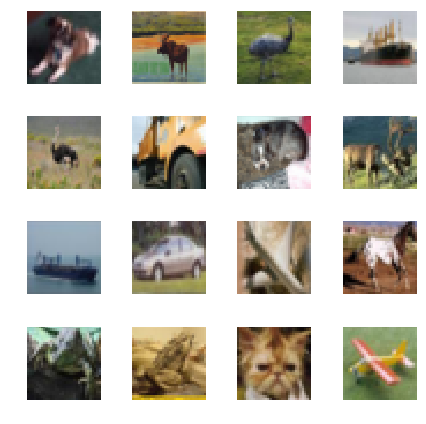

In [199]:
# CIFAR
train_loader, test_loader, classes = datasets.get_cifar_loader()
inputs,targets = next(iter(train_loader))
print(inputs.size())
utils.imgs.plot_rgb_samples(inputs)

## Im2col

* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/im2col.py
* http://cs231n.github.io/convolutional-networks/#convert
* Convert a sliding window convolution into a single matrix multiplication by stretching out the filter

In [200]:
from utils.im2col import *


## Weight Initialization

* https://isaacchanghau.github.io/2017/05/24/Weight-Initialization-in-Artificial-Neural-Networks/
* https://stats.stackexchange.com/questions/47590/what-are-good-initial-weights-in-a-neural-network

In [201]:
def gaussian_init(dims):
    # Values are draw from normal distribution with mean 0 and variance 1
    return np.random.randn(*dims)

def uniform_init(low=-0.05, high=0.05, dims=None):
    # Values are draw from range [low, high) with equal probability
    # Includes low, excludes high
    return np.random.uniform(low, high, dims)

def xavier_init(X):
    pass

## Convolution Layer

* https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/
* https://github.com/zishansami102/CNN-from-Scratch/blob/master/CIFAR-10/convnet.py
* https://github.com/dreamgonfly/cnn-from-scratch
* https://github.com/utkarshojha/cnn-from-scratch/blob/master/cnn.py
* https://github.com/wiseodd/hipsternet/blob/master/hipsternet/layer.py
* http://gluon.mxnet.io/chapter04_convolutional-neural-networks/cnn-scratch.html

In [202]:
def pad(inp, padding):
    bs,c,h,w = inp.shape
    pad_inp = np.zeros((bs, c, h+2*padding, w+2*padding))
    pad_inp[:,:,padding:h+padding,padding:w+padding] = inp
    return pad_inp

def convolve_batch(batch, kernels, bias, padding, stride):
    bs,c,h,w = batch.shape
    n_ks,kc,kh,kw = kernels.shape
    assert c == kc
    #print("Batch", batch.shape, "Filters", kernels.shape)
    out_h = (h - kh + 2*padding) // stride + 1
    out_w = (w - kw + 2*padding) // stride + 1
    out = np.zeros((bs, n_ks, out_h, out_w))
    batch = pad(batch, padding)
    #print("Out", out.shape)
    for inp_idx, inp in enumerate(batch):
        for k_idx, kernel in enumerate(kernels):
            out[inp_idx][k_idx] = convolve(inp, kernel, bias[k_idx], stride)
    return out
    
def convolve(inp, kernel, bias, stride):
    c,h,w = inp.shape
    kc,kh,kw = kernel.shape
    assert c == kc
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((1, out_h, out_w))
    out_row = 0
    for row in range(0, h-kh+1, stride):
        out_col = 0
        for col in range(0, w-kw+1, stride):
            for chan in range(c):
                # Elementwise multiply then sum for sliding window approach
                # Same as dot product of two flattened vectors
                dp = inp[chan, row:row+kh, col:col+kw] * kernel[chan]
                dp = np.sum(dp) + bias
                out[0, out_row, out_col] += dp
            out_col += 1
        out_row += 1
    out += bias
    return out / kc

In [203]:
inp = np.ones((1,3,5,5))
kernels = gaussian_init((2,3,3,3))
bias = np.zeros((2,1,1))
out = convolve_batch(inp, kernels, bias, padding=1, stride=2)
out.shape, out

((1, 2, 3, 3), array([[[[-0.48902195, -1.06957812, -1.22551706],
          [-0.70189281, -1.2535652 , -2.33586425],
          [ 0.01620737, -0.30151603, -1.65368466]],
 
         [[-0.49896263,  1.20593579,  1.4265477 ],
          [-1.05676109,  0.05898944,  0.2953113 ],
          [-0.8010397 , -0.08335863,  0.33313575]]]]))

In [204]:
class Convolution():
    def __init__(self, in_chans, n_filters, fs=(3,3), 
                 stride=1, padding=1, init=gaussian_init):
        self.filters = init((n_filters, in_chans, fs[0], fs[1]))
        self.bias = np.zeros((n_filters, 1, 1, 1))
        self.stride = stride
        self.padding = padding
        
    def forward(self, X):
        return convolve_batch(X, self.filters, self.bias, self.padding, self.stride)
        
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [205]:
conv = Convolution(in_chans=3, n_filters=2, fs=(3,3), stride=1, padding=1)
inp = np.ones((1,3,5,5))
conv(inp)

array([[[[-1.44560686, -2.07943847, -2.07943847, -2.07943847, -0.29655045],
         [ 0.1223278 ,  0.7004158 ,  0.7004158 ,  0.7004158 ,  1.69204372],
         [ 0.1223278 ,  0.7004158 ,  0.7004158 ,  0.7004158 ,  1.69204372],
         [ 0.1223278 ,  0.7004158 ,  0.7004158 ,  0.7004158 ,  1.69204372],
         [ 0.57029908,  1.6918032 ,  1.6918032 ,  1.6918032 ,  1.5719701 ]],

        [[ 0.40588787,  0.7161729 ,  0.7161729 ,  0.7161729 , -0.14119231],
         [ 0.01665631,  0.83439266,  0.83439266,  0.83439266,  0.17643302],
         [ 0.01665631,  0.83439266,  0.83439266,  0.83439266,  0.17643302],
         [ 0.01665631,  0.83439266,  0.83439266,  0.83439266,  0.17643302],
         [ 0.1073252 ,  0.64350932,  0.64350932,  0.64350932,  0.16992926]]]])

## MaxPooling Layer

In [206]:
def pool_batch(batch, ksize, stride):
    bs, c, h, w = batch.shape
    kh, kw = ksize
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((bs, c, out_h, out_w))
    for idx, inp in enumerate(batch):
        out[idx,:,:,:] = pool(inp, ksize, stride)
    return out

def pool(inp, ksize, stride):
    c, h, w = inp.shape
    kh, kw = ksize
    out_h = (h - kh) // stride + 1
    out_w = (w - kw) // stride + 1
    out = np.zeros((c, out_h, out_w))
    out_row = 0
    for row in range(0, h-kh+1, stride):
        out_col = 0
        for col in range(0, w-kw+1, stride):
            out_pool = np.amax(inp[:, row:row+kh, col:col+kw], axis=(1,2))
            out[:, out_row, out_col] = out_pool
            out_col += 1
        out_row += 1
    return out

In [207]:
inp = gaussian_init((1,2,4,4))
ksize = (2,2)
stride = 2
out = pool_batch(inp, ksize, stride)
inp,out

(array([[[[-0.82498714,  0.05458159, -1.65968039, -1.31094997],
          [ 0.13027232,  0.02703091,  0.76275849,  1.77293277],
          [ 0.23316315, -1.13511838, -1.00684594, -0.65887148],
          [-0.23556026, -0.39706151,  0.42262774, -1.09854019]],
 
         [[-1.56177935,  0.3363952 ,  0.62760369, -0.64604704],
          [ 0.52997718,  2.47632867, -0.0688836 ,  0.6607018 ],
          [-1.60487645,  0.77506731,  0.03962238, -0.27267565],
          [-1.06636404, -2.21356952,  1.00699544, -1.97764789]]]]),
 array([[[[ 0.13027232,  1.77293277],
          [ 0.23316315,  0.42262774]],
 
         [[ 2.47632867,  0.6607018 ],
          [ 0.77506731,  1.00699544]]]]))

In [208]:
class MaxPool():
    def __init__(self, ksize=(2,2), stride=2):
        self.ksize = ksize
        self.stride = stride
    
    def forward(self, X):
        return pool_batch(X, self.ksize, self.stride)
    
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [209]:
maxpool = MaxPool(ksize=(2,2), stride=2)
inp = gaussian_init((2,2,4,4))
maxpool(inp)

array([[[[ 1.54183224,  1.67332906],
         [ 0.30743123,  0.60991988]],

        [[ 1.04502965,  1.60193623],
         [ 0.86314903,  1.68260619]]],


       [[[ 0.11891297,  0.08244682],
         [ 0.82661709,  1.12995216]],

        [[ 0.30956805,  1.13958853],
         [ 0.10222891,  0.15589777]]]])

## Activation Layer

In [210]:
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, X):
        return np.maximum(0, X)
    
    def backward(self, X):
        X = X.copy()
        X[X < 0] = 0
        X[X > 0] = 1
        return X
    
    def __call__(self, X):
        return self.forward(X)

class Sigmoid():
    def __init__(self):
        pass
    
    def forward(self, X):
        return self._sigmoid(X)
    
    def backward(self, X):
        return self._sigmoid(X) * (1 - self._sigmoid(X))
        
    def _sigmoid(self, X):
        return 1.0 / (1 + np.exp(-X))
    
    def __call__(self, X):
        return self.forward(X)

In [211]:
inp = gaussian_init((2,2,4,4))
relu = ReLU()
relu(inp)

array([[[[ 0.06106611,  0.37779554,  0.03025897,  1.85542388],
         [ 0.        ,  0.        ,  0.38548187,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.53447726],
         [ 0.        ,  0.        ,  0.        ,  0.73738669]],

        [[ 1.07857929,  0.        ,  0.        ,  0.52277026],
         [ 0.88734287,  0.        ,  0.7302527 ,  0.68900113],
         [ 0.        ,  0.        ,  0.55218134,  0.        ],
         [ 0.        ,  0.90924515,  0.        ,  0.        ]]],


       [[[ 0.        ,  0.        ,  0.48240044,  0.94042526],
         [ 0.2873741 ,  0.57174343,  0.12344286,  1.81552481],
         [ 0.        ,  0.92789016,  0.02554638,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.70307233]],

        [[ 0.87562497,  0.53652007,  0.25840491,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.70507984],
         [ 0.        ,  0.83693107,  0.        ,  1.54774492],
         [ 0.89336642,  0.05302017,  0.        

In [212]:
inp = gaussian_init((2,2,4,4))
sigmoid = Sigmoid()
sigmoid(inp)

array([[[[ 0.71101712,  0.48870533,  0.92086147,  0.61782049],
         [ 0.62246192,  0.65417112,  0.61503949,  0.54136781],
         [ 0.50843027,  0.65039079,  0.32491933,  0.83438111],
         [ 0.89693362,  0.64033771,  0.35842627,  0.78567738]],

        [[ 0.91871905,  0.37862942,  0.42303176,  0.12816646],
         [ 0.68191842,  0.28330849,  0.43629336,  0.88600936],
         [ 0.55824026,  0.53553105,  0.11007976,  0.37430621],
         [ 0.52135719,  0.57105225,  0.13409501,  0.38361368]]],


       [[[ 0.68747291,  0.56215773,  0.72092539,  0.64661043],
         [ 0.23540805,  0.17390621,  0.16226531,  0.83846247],
         [ 0.44727561,  0.68629442,  0.32535185,  0.22641638],
         [ 0.50146059,  0.70735772,  0.49558389,  0.3863408 ]],

        [[ 0.77048798,  0.1340168 ,  0.19654625,  0.5281523 ],
         [ 0.83220024,  0.03977007,  0.78678762,  0.26487363],
         [ 0.51091379,  0.24965999,  0.23411545,  0.5793711 ],
         [ 0.33335292,  0.5303618 ,  0.58527911

## Dropout

* Binomial distribution vs Gaussian
* Gaussian = continuous centered around mean
    - Example: Height of a person
* Binomial = discrete, yes/no distribution, with p probabilty, over n trials
    - Example: Rolling a 6-sided die, 10 times (p=1/6, n=10)

In [213]:
def dropout(inp, p=0.05):
    # p: probability of dropout
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.binomial.html
    # https://en.wikipedia.org/wiki/Binomial_distribution
    # Binomial distribution - probability of yes/no for n trials
    mask = np.random.binomial(n=1, p=1-p, size=inp.shape)
    return mask * inp

In [214]:
class Dropout():
    def __init__(self, p=0.05):
        self.p = p
    
    def forward(self, X):
        return dropout(X, self.p)
    
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [215]:
drop = Dropout(p=0.05)
inp = gaussian_init((2,2,4,4))
drop(inp)

array([[[[-2.14689448,  0.61381142, -1.04349849, -1.204327  ],
         [ 0.75498845,  1.84162623,  0.96294901,  1.06606494],
         [ 1.60144542,  0.76559025,  0.70117885, -0.54750109],
         [-0.2582758 , -0.5243086 , -0.70120411, -0.6816503 ]],

        [[ 1.69409605,  1.45388921, -2.70999274, -0.        ],
         [ 0.08105632,  1.17416181,  0.01539352, -1.6613327 ],
         [-0.67468238, -0.75272366, -1.31150288,  0.08230159],
         [-0.67337094, -0.91860072, -0.89697911,  0.86240607]]],


       [[[ 0.16398307, -1.55755472, -1.01160322,  0.44945187],
         [ 1.63308598, -0.29465473,  0.79672578,  0.        ],
         [-1.69164204, -1.54032862,  1.31196578,  0.55675547],
         [-0.0200119 ,  0.57725091, -0.10406211, -0.27917817]],

        [[-0.3418503 , -1.28200177, -0.59985906,  0.52333283],
         [ 1.98951406,  0.        ,  0.44171331,  0.03801549],
         [-0.48177401, -0.32214459,  0.37925336, -0.06030048],
         [-0.11484461, -0.45463465, -0.12630921

## Batch Norm

In [216]:
class BatchNorm():
    def __init__(self):
        pass
    
    def forward(self, X):
        return X
    
    def backward(self, X):
        return X
    
    def __call__(self, X):
        return self.forward(X)

## Linear

In [217]:
def flatten(X):
    bs = X.shape[0]
    return X.reshape((bs,-1))

In [218]:
class Linear():
    def __init__(self, in_feats, out_feats, init=uniform_init):
        self.weights = init(dims=(in_feats, out_feats))
        self.bias = np.array([1.0])
        self.out_feats = out_feats
    
    def forward(self, X):
        assert len(X.shape) == 2
        return X @ self.weights + self.bias
        
    def backward(self, X):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [219]:
inp = np.random.randn(1,128)
linear = Linear(in_feats=128, out_feats=12)
linear(inp)

array([[ 0.50460225,  1.11952389,  0.34465337,  1.555363  ,  0.72680457,
         1.32191283,  1.37338531,  0.48896586,  1.05642213,  1.21345131,
         0.91566336,  0.74549135]])

## Model

In [220]:
class CNN():
    def __init__(self, input_dims):
        c,h,w = input_dims
        self.conv = Convolution(in_chans=c, n_filters=3, stride=1, padding=1)
        self.relu = ReLU()
        self.dropout = Dropout(p=0.05)
        self.maxpool = MaxPool(ksize=(2,2), stride=2)
        self.linear = Linear(in_feats=(h//2) * (w//2) * 3, out_feats=12)
        self.sigmoid = Sigmoid()
    
    def forward(self, X):
        out = self.conv(X)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.maxpool(out)
        out = flatten(out)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out
    
    def backward(self, loss_func, X, y):
        pass
    
    def __call__(self, X):
        return self.forward(X)

In [221]:
inp = np.random.randn(1,3,8,8)
model = CNN(input_dims=(3,8,8))
model(inp)

array([[ 0.80391539,  0.70698524,  0.70869318,  0.75995332,  0.73361249,
         0.71306064,  0.7522631 ,  0.63631062,  0.77732337,  0.81636846,
         0.59539682,  0.63833941]])

## Loss Function

* https://www.ics.uci.edu/~pjsadows/notes.pdf
* https://deepnotes.io/softmax-crossentropy

In [222]:
def cross_entropy(preds, targs):
    '''
    BCE: -(targs*log(preds) + (1-targs)*log(1-preds)) / len(preds)
    '''
    # Take the error when label=1
    cost1 = -targs * np.log(preds)

    # Take the error when label=0
    cost0 = (1 - targs) * np.log(1 - preds)

    #Take the sum of both costs
    cost = cost1 - cost0

    #Take the average cost
    cost = cost.sum() / len(preds)

    return cost

class CrossEntropy():
    def __init__(self):
        pass
    
    def forward(self, preds, targs):
        return cross_entropy(preds, targs)
    
    def backward(self, preds, targs):
        return preds - targs
    
    def __call__(self, preds, targs):
        return self.forward(preds, targs)

In [223]:
preds = np.array([.1, .9, .1])
targs = np.array([0, 1, 0])
bce = CrossEntropy()
bce(preds, targs)

0.10536051565782628

## SGD

In [224]:
def SGD(data, batch_size, lr):
    N = len(data)
    np.random.shuffle(data)
    mini_batches = np.array([data[i:i+batch_size] for i in range(0, N, batch_size)])
    for X,y in mini_batches:
        backprop(X, y, lr)

## Train

In [191]:
def train(model, inputs, targs, loss_func):
    
    for inp,targ in zip(inputs,targs):
    
        preds = model(inputs)

        loss = loss_func(preds, targs)

        model.backward(loss, preds, targs)    

## PyTorch

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_shape, n_classes):
        super().__init__()
        c,w,h = in_shape
        n_pool = 3
        w = int(w / 2**n_pool)
        h = int(h / 2**n_pool)
        self.features = nn.Sequential(
            nn.Conv2d(c, 8, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), #size/2
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*w*h, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Train

In [ ]:
model = CNN(in_shape=(3,32,32), n_classes=10).cuda()

In [ ]:
inputs,targets = next(iter(train_loader))
output = model(Variable(inputs.cuda()))
output.size()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
lr_adjuster = learning_rates.FixedLR(initial_lr=1e-3, iteration_type='epoch')
trainer = training.QuickTrainer()
trainer.run(model, train_loader, test_loader, criterion, optimizer, epochs=10)

In [ ]:
plt.plot(np.stack([trainer.metrics['loss']['trn'], trainer.metrics['loss']['tst']], 1))

## Sources

* https://github.com/bfortuner/ml-study/blob/master/NeuralNetworkReLU.ipynb
* https://wiseodd.github.io/techblog/2016/07/16/convnet-conv-layer/
* http://cs231n.github.io/convolutional-networks/